In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import KFold
import NN_functions as NN_p

/Users/thomasdixon/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/thomasdixon/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/thomasdixon/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/thomasdixon/anaconda3/lib/python3.7/site-packages/tensorf

In [2]:
num_data_points = 100
Z = NN_p.create_data(num_data_points)

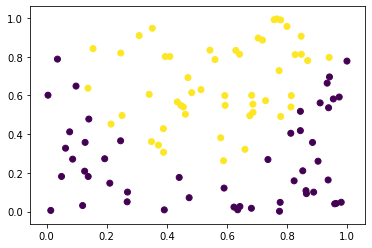

In [3]:
X = Z[:,:-1]
y = Z[:,-1]
y = y.reshape(-1,1)

c = y.T[0]
plt.scatter(*zip(*X), c=c)
plt.show()

In [4]:
def KFold_iteration_Basic(Z, layers, n_splits):
    cv = KFold(n_splits=n_splits, shuffle=False)

    all_accuracies = []
    test_accuracies = []
    for i, (train_index, test_index) in enumerate(cv.split(Z)):
        #print("Train Index: ", train_index, "\n")
        #print("Test Index: ", test_index)

        print('Split ', i)
        #SPLIT DATA
        Z_train, Z_test = Z[train_index], Z[test_index]

        #RUN NN
        nn = NN_p.NN(layers, learning_rate = 0.1)

        accuracies = nn.train(Z_train,500)
        all_accuracies.append(accuracies)

        #TEST NN
        X_test, y_test = Z_test[:,:-1], Z_test[:,-1]
        y_test = y_test.reshape(-1,1)

        predictions = nn.predict(X_test)
        acc = nn.evaluate(predictions,y_test)

        test_accuracies.append(acc)
    
    return all_accuracies, test_accuracies

In [5]:
all_layers = [
    [2,2,1], [2,3,1], [2,4,1], [2,5,1], [2,6,1], [2,7,1], [2,8,1],
    [2,2,2,1], [2,2,4,1], [2,2,6,1]
]

n_splits = 10

for i in range(len(all_layers)):
    layers = all_layers[i]
    
    
    all_accs, test_accs = KFold_iteration_Basic(Z, layers, n_splits)
    print(layers)
    print("Testing accuracies: ", np.array(test_accs).mean())
    print("Training accuracies: ", np.array(all_accs)[:,-1].mean())

Split  0
Split  1
Split  2
Split  3
Split  4
Split  5
Split  6
Split  7
Split  8
Split  9
[2, 2, 1]
Testing accuracies:  0.78
Training accuracies:  0.8233333333333333
Split  0
Split  1
Split  2
Split  3
Split  4
Split  5
Split  6
Split  7
Split  8
Split  9
[2, 3, 1]
Testing accuracies:  0.78
Training accuracies:  0.8266666666666665
Split  0
Split  1
Split  2
Split  3
Split  4
Split  5
Split  6
Split  7
Split  8
Split  9
[2, 4, 1]
Testing accuracies:  0.7899999999999999
Training accuracies:  0.8244444444444443
Split  0
Split  1
Split  2
Split  3
Split  4
Split  5
Split  6
Split  7
Split  8
Split  9
[2, 5, 1]
Testing accuracies:  0.77
Training accuracies:  0.8288888888888888
Split  0
Split  1
Split  2
Split  3
Split  4
Split  5
Split  6
Split  7
Split  8
Split  9
[2, 6, 1]
Testing accuracies:  0.76
Training accuracies:  0.8244444444444443
Split  0
Split  1
Split  2
Split  3
Split  4
Split  5
Split  6
Split  7
Split  8
Split  9
[2, 7, 1]
Testing accuracies:  0.79
Training accuracies:  0.8

In [5]:
def KFold_iteration_Keras(Z, layers, n_splits):
    cv = KFold(n_splits=n_splits, shuffle=False)

    all_accuracies = []
    test_accuracies = []
    for i, (train_index, test_index) in enumerate(cv.split(Z)):
        #print("Train Index: ", train_index, "\n")
        #print("Test Index: ", test_index)

        print('Split ', i)
        #SPLIT DATA
        Z_train, Z_test = Z[train_index], Z[test_index]

        #Build Layers
        for j, l in enumerate(layers):
            if j == 0:
                inputs = keras.Input(shape=(l))
                x = inputs
                continue
            x = keras.layers.Dense(l, activation="sigmoid")(x)
        
        outputs = x

        
        #RUN NN
        model = keras.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.0),
              loss=tf.keras.losses.MeanSquaredError(),
             metrics=[tf.keras.metrics.BinaryAccuracy()])
        
        X_train, y_train = Z_train[:,:-1], Z_train[:,-1]
        y_train = y_train.reshape(-1,1)
        
        history = model.fit(X_train, y_train, batch_size=1, epochs=500, verbose=0)
        
        all_accuracies.append(history)
        
        #TEST NN
        X_test, y_test = Z_test[:,:-1], Z_test[:,-1]
        y_test = y_test.reshape(-1,1)
        
        results = model.evaluate(X_test, y_test, batch_size=1, verbose=0)

        test_accuracies.append(results)
    
    return all_accuracies, test_accuracies

In [6]:
all_layers = [
    [2,2,1]#, [2,3,1], [2,4,1], [2,5,1], [2,6,1], [2,7,1], [2,8,1],
    #[2,2,2,1], [2,2,4,1], [2,2,6,1]
]

n_splits = 10

for i in range(len(all_layers)):
    layers = all_layers[i]
    
    
    all_accs, test_accs = KFold_iteration_Keras(Z, layers, n_splits)
    print(layers)
    print("Testing accuracies: ", np.array(test_accs)[:,1].mean())
    print("Training accuracies: ", np.mean([i.history['binary_accuracy'][-1] for i in all_accs]))

Split  0
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Split  1
Split  2
Split  3
Split  4
Split  5
Split  6
Split  7
Split  8
Split  9
[2, 2, 1]
